In [1]:
from pathlib import Path
import imageio.v3 as iio
import pandas as pd
import numpy as np
import datetime as dt
from PIL import Image
from IPython.display import display

In [2]:
mkv_folder_d = Path('D:\\') / 'docs' / 'OBS D'
mkv_folder_f = Path('F:\\') / 'OBS F'

image_root_folder = Path('./imgs')
image_output_folder = image_root_folder / 'test'
image_output_folder.mkdir(parents=True, exist_ok=True)  # create folder(s) if not exists

In [32]:
# define scaled size of all frames
frame_size_ratio = 1/4
frame_size = tuple((frame_size_ratio * np.array([1920, 1080])).astype(int))
frame_size

(480, 270)

In [4]:
def iter_all_mkv_files():
    for file in mkv_folder_d.iterdir():
        yield file
    for file in mkv_folder_f.iterdir():
        yield file

all_mkv_files = list(iter_all_mkv_files())

In [5]:
def files_to_row():
    for file in iter_all_mkv_files():
        stat = file.stat()
        yield {
            #"path": file.resolve().as_posix(),
            "file": file,
            "created": dt.datetime.fromtimestamp(stat.st_ctime).strftime('%d/%m %H:%M'),
            "file_size": stat.st_size / (1024 ** 3)
        }

df = pd.DataFrame(data=files_to_row())
df

,file,created,file_size
0,D:\docs\OBS D\2022-03-27 17-49-23.mkv,27/03 17:49,73.588729
1,D:\docs\OBS D\2022-03-28 22-58-35.mkv,28/03 22:58,41.075041
2,F:\OBS F\2022-03-30 21-20-27.mkv,15/04 22:06,36.324882
3,F:\OBS F\2022-04-01 00-02-19.mkv,01/04 00:02,52.032538
4,F:\OBS F\2022-04-03 15-57-14.mkv,03/04 15:57,53.516733
5,F:\OBS F\2022-04-04 00-26-57.mkv,04/04 00:26,34.573906
6,F:\OBS F\2022-04-04 21-25-38.mkv,04/04 21:25,8.250817
7,F:\OBS F\2022-04-04 23-43-34.mkv,04/04 23:43,57.492331
8,F:\OBS F\2022-04-07 17-00-34.mkv,07/04 17:00,31.070012
9,F:\OBS F\2022-04-07 22-17-48.mkv,07/04 22:17,91.428535


In [6]:
# Find smallest file
smallest_file_row = df.sort_values(by='file_size').iloc[0]
smallest_file_row.name # index value, not file name

14

In [7]:
# test with smallest file
test_file = smallest_file_row.file
smallest_file_row

file         F:\OBS F\2022-04-14 23-10-42.mkv
created                           14/04 23:10
file_size                            0.005869
Name: 14, dtype: object

In [8]:
mkv_bytes = test_file.read_bytes()

In [9]:
# extract first frame using imageio
first_frame = iio.imread(mkv_bytes, format_hint=".mkv")
first_frame.shape

(1080, 1920, 3)

In [10]:
def resize_frame(frame):
    return np.array(Image.fromarray(frame).resize(frame_size))
    
img = Image.fromarray(first_frame).resize(frame_size)
iio.imwrite(image_root_folder / 'test_write.png', np.array(img), format_hint='.png')

In [28]:
def iter_frames(file, fps=0.5):
    #mkv_bytes = file.read_bytes()
    frames = iio.imiter(file, format_hint=".mkv", fps=fps)
    for frame in frames:
        yield frame

def iter_test_frames(**kwargs):
    return iter_frames(df.iloc[14].file, **kwargs)

def iter_very_long_frames(**kwargs):
    return iter_frames(df.iloc[6].file, **kwargs)

In [12]:
def test_with_smallest():
    image_folder = image_output_folder / 'test'
    image_folder.mkdir(parents=True, exist_ok=False)

    for frame_ix, frame_data in enumerate(iter_test_frames()):
        image_file = image_folder / f"image_{frame_ix:06d}.png"
        frame_data = resize_frame(frame_data)
        iio.imwrite(image_file, frame_data, format_hint='.png')
        #frame_image = Image.fromarray(frame_data)
        #display(frame_image)

In [13]:
def make_images_from_longer_video():
    image_folder = image_output_folder / 'video6'
    image_folder.mkdir(parents=True, exist_ok=False)

    for frame_ix, frame_data in enumerate(iter_very_long_frames()):
        image_file = image_folder / f"image_{frame_ix:06d}.png"
        frame_data = resize_frame(frame_data)
        iio.imwrite(image_file, frame_data, format_hint='.png')
        if frame_ix == 0 or frame_ix % 100 == 0:
            frame_image = Image.fromarray(frame_data)
            display(frame_image)

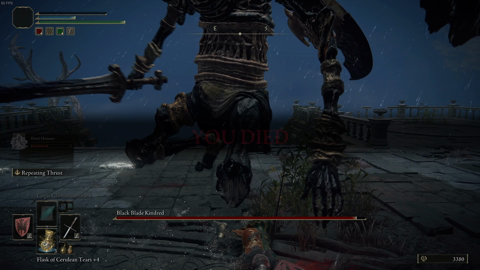

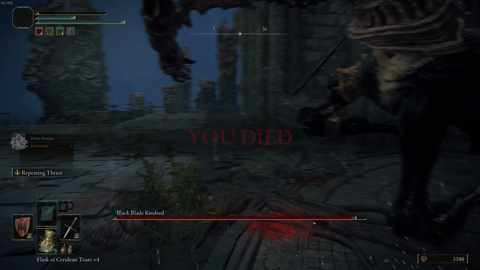

In [14]:
# images found after using make_images_from_longer_video() in an earlier run
death1_im = iio.imread(image_root_folder / 'death_examples' / 'low_res_death1.png')
death2_im = iio.imread(image_root_folder / 'death_examples' / 'low_res_death2.png')

display(Image.fromarray(death1_im))
display(Image.fromarray(death2_im))

'Image shape (270, 480, 3) cropped to region x:(177, 302) y:(110, 164) with shape (54, 125, 3)'

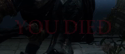

'Image shape (270, 480, 3) cropped to region x:(177, 302) y:(110, 164) with shape (54, 125, 3)'

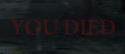

In [15]:
def get_death_text_crop(im, debug=False):
    y, x, nchans = im.shape
    
    x_margin = 0.37
    y_margin = 0.40
    x_offset = 0
    y_offset = 0.01

    x_min = int(x * (x_margin + x_offset))
    x_max = int(x * ((1 - x_margin) + x_offset))
    y_min = int(y * (y_margin + y_offset))
    y_max = int(y * ((1 - y_margin) + y_offset))
    
    cropped = im[y_min: y_max, x_min:x_max, :]
    
    if debug:
        display(f'Image shape {im.shape} cropped to region x:{x_min, x_max} y:{y_min, y_max} with shape {cropped.shape}')

    return cropped

for im_ix, im in enumerate([death1_im, death2_im]):
    display(Image.fromarray(get_death_text_crop(im, debug=True)))

In [16]:
def make_cropped_images_from_longer_video():
    image_folder = image_output_folder / 'video6_cropped'
    image_folder.mkdir(parents=True, exist_ok=False)

    for frame_ix, frame_data in enumerate(iter_very_long_frames(fps=1)):
        image_file = image_folder / f"image_{frame_ix:06d}.png"
        frame_data = resize_frame(frame_data)
        cropped = get_death_text_crop(frame_data)
        iio.imwrite(image_file, cropped, format_hint='.png')
        if frame_ix == 0 or frame_ix % 200 == 0:
            display(Image.fromarray(cropped))
#make_cropped_images_from_longer_video()

In [17]:
# Figure out max necessary digits in frame name to keep it alphabetically increasing file names in cronological order
# Assumes 1000 hours with 1 fps is overkill and more than sufficient...
max_n_frames_assumed = 60*60*1000
print(f'With {max_n_frames_assumed} images, we need {np.ceil(np.log10(max_n_frames_assumed))} digits')

With 3600000 images, we need 7.0 digits


In [30]:
def make_cropped_images_from_file(file, output_folder, filename_ix_start=0, **kwargs):
    filename_frame_ix = filename_ix_start
    print(f' Writing frames from {file} to {output_folder}, starting with index {filename_ix_start}')
    for frame_ix, frame_data in enumerate(iter_frames(file, fps=1, **kwargs)):
        filename_frame_ix = frame_ix + filename_ix_start
        image_file = output_folder / f"image_{filename_frame_ix:07d}.png"
        frame_data = resize_frame(frame_data)
        cropped = get_death_text_crop(frame_data)
        iio.imwrite(image_file, cropped, format_hint='.png')
        
        if frame_ix % 3600 == 0:
            # display image every hour of video time
            display(Image.fromarray(cropped))
    n_images_written = filename_frame_ix - filename_ix_start
    print(f'\t Created {n_images_written} images.')
    print(f'Done with {file}')
    # Return filename frame index so next file may continue
    return filename_frame_ix
                
def make_cropped_images_from_all_files():
    for file_ix, file in enumerate(iter_all_mkv_files()):
        file_size_in_GB = file.stat().st_size / (1024 ** 3)
        print(f'\nFile {file_ix:<3} {file_size_in_GB:>10.1f}GB {file.stem:>28}')    
    
        image_folder = image_output_folder / 'cropped' / file.stem
        if image_folder.exists():
            print(' > Folder exists, therefore skipping file.')
            continue
        image_folder.mkdir(parents=True, exist_ok=False)
        make_cropped_images_from_file(file, image_folder)


File 0         73.6GB          2022-03-27 17-49-23
 > Folder exists, therefore skipping file.

File 1         41.1GB          2022-03-28 22-58-35
 > Folder exists, therefore skipping file.

File 2         36.3GB          2022-03-30 21-20-27
 > Folder exists, therefore skipping file.

File 3         52.0GB          2022-04-01 00-02-19
 > Folder exists, therefore skipping file.

File 4         53.5GB          2022-04-03 15-57-14
 > Folder exists, therefore skipping file.

File 5         34.6GB          2022-04-04 00-26-57
 > Folder exists, therefore skipping file.

File 6          8.3GB          2022-04-04 21-25-38
 > Folder exists, therefore skipping file.

File 7         57.5GB          2022-04-04 23-43-34
 > Folder exists, therefore skipping file.

File 8         31.1GB          2022-04-07 17-00-34
 > Folder exists, therefore skipping file.

File 9         91.4GB          2022-04-07 22-17-48
 > Folder exists, therefore skipping file.

File 10       101.0GB          2022-04-09 19-28-3

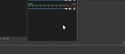

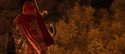

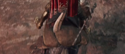

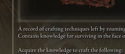

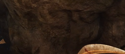

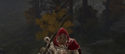

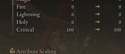

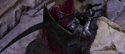

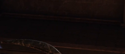

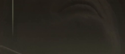

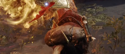

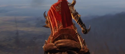

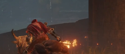

	 Created 44395 images.
Done with F:\OBS F\2022-04-10 22-27-37.mkv

File 12        61.5GB          2022-04-11 20-51-44
 > Folder exists, therefore skipping file.

File 13        40.1GB          2022-04-12 21-28-03
 > Folder exists, therefore skipping file.

File 14         0.0GB          2022-04-14 23-10-42
 > Folder exists, therefore skipping file.

File 15        18.3GB          2022-04-14 23-11-32
 > Folder exists, therefore skipping file.


In [31]:
make_cropped_images_from_all_files()

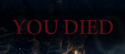

In [20]:
a_folder =  image_output_folder / 'cropped' / '2022-03-27 17-49-23'
a_death_file = a_folder / 'image_0017928.png'

dim_data = iio.imread(a_death_file)
dim = Image.fromarray(dim_data)
dim

In [21]:
dim_data.shape

(54, 125, 3)

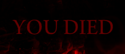

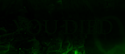

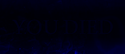

In [22]:


for color in range(3):
    dim_data = iio.imread(a_death_file)
    not_channel_mask = [channel != color for channel in range(3)]
    dim_data[:,:, not_channel_mask ] = 0

    dim = Image.fromarray(dim_data)
    display(dim)